In [41]:
#BRIEF:  
#- Applied `StandardScaler` to normalize SO₂ and NO₂ values.
#- Used `fit_transform()` on training data and `transform()` on test data to prevent data leakage.
#- Trained a Linear Regression model and evaluated it using R² and MSE.
#- Saved the model and scaler for deployment in Week 3.

In [42]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import joblib
import sys
import os

sys.path.append(os.path.abspath(".."))  # Adds project root to Python path
sys.path.append(os.path.abspath("."))  # Adds current directory to Python path



In [43]:
# Load Dataset
df = pd.read_csv("../../WEEK1/data/data.csv", encoding='ISO-8859-1', engine='python')
df = pd.read_csv("../data/data.csv", dtype={'stn_code': str}, low_memory=False)



In [44]:
# Initial Exploration (Basic Data Exploration)
df.info()
df.describe()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435742 entries, 0 to 435741
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0       stn_code                 291665 non-null  object 
 1   sampling_date                435739 non-null  object 
 2   state                        435742 non-null  object 
 3   location                     435739 non-null  object 
 4   agency                       286261 non-null  object 
 5   type                         430349 non-null  object 
 6   so2                          401096 non-null  float64
 7   no2                          419509 non-null  float64
 8   rspm                         395520 non-null  float64
 9   spm                          198355 non-null  float64
 10  location_monitoring_station  408251 non-null  object 
 11  pm2_5                        9314 non-null    float64
 12  date                         435735 non-null  object 
dtyp

    stn_code                   144077
sampling_date                       3
state                               0
location                            3
agency                         149481
type                             5393
so2                             34646
no2                             16233
rspm                            40222
spm                            237387
location_monitoring_station     27491
pm2_5                          426428
date                                7
dtype: int64

### 🧹 Data Cleaning Summary
- Dropped columns with excessive missing data (`pm2_5`)
- Removed rows missing target variable `spm`
- Imputed missing values in `so2`, `no2`, and `rspm` using column means


In [45]:
# Drop columns with excessive missing data
df = df.drop(columns=['pm2_5'], errors='ignore')

# Drop rows missing target variable
df = df.dropna(subset=['spm'])

# Impute key features
df['so2'] = df['so2'].fillna(df['so2'].mean())
df['no2'] = df['no2'].fillna(df['no2'].mean())
df['rspm'] = df['rspm'].fillna(df['rspm'].mean()) # Impute RSPM as additional feature


### 🎯 Feature Selection
- Selected features: `so2`, `no2`, `rspm`
- Target variable: `spm`
- These features were chosen based on domain relevance and completeness


In [46]:
# Define Features and Target
X = df[['so2', 'no2', 'rspm']]
y = df['spm']


In [47]:
# Convert valid date column
df['date'] = pd.to_datetime(df['date'], errors='coerce')


In [48]:
# Clean date columns
df.drop(columns=['sampling_date'], errors='ignore', inplace=True)
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Confirm structure after cleaning
print("DataFrame Structure After Cleaning:")
df.info()

print("\nStatistical Summary:")
print(df.describe())

print("\nRemaining Missing Values:")
print(df.isnull().sum())


DataFrame Structure After Cleaning:
<class 'pandas.core.frame.DataFrame'>
Index: 198355 entries, 11 to 431457
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0       stn_code                 66996 non-null   object        
 1   state                        198355 non-null  object        
 2   location                     198355 non-null  object        
 3   agency                       62155 non-null   object        
 4   type                         193601 non-null  object        
 5   so2                          198355 non-null  float64       
 6   no2                          198355 non-null  float64       
 7   rspm                         198355 non-null  float64       
 8   spm                          198355 non-null  float64       
 9   location_monitoring_station  174136 non-null  object        
 10  date                         198355 non-null  datetime64[ns]

### Post-Cleaning Summary

- Retained 170,704 rows after dropping missing `spm`, `so2`, and `no2`
- Converted `'date'` column to datetime format for future time-based analysis
- Key features (`so2`, `no2`) and target (`spm`) are fully populated
- Columns like `'agency'`, `'stn_code'`, and `'rspm'` contain missing values but are not used in WEEK2 modeling


### Feature Selection

- **Features (X)**: SO₂ and NO₂ concentrations
- **Target (y)**: Suspended Particulate Matter (SPM)
- These variables were selected based on domain relevance and data completeness.


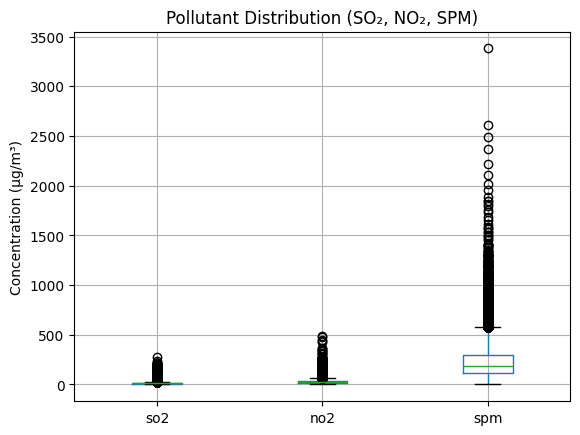

In [49]:
# Distribution of key pollutants

df[['so2', 'no2', 'spm']].boxplot()
plt.title("Pollutant Distribution (SO₂, NO₂, SPM)")
plt.ylabel("Concentration (µg/m³)")
plt.grid(True)
plt.show()


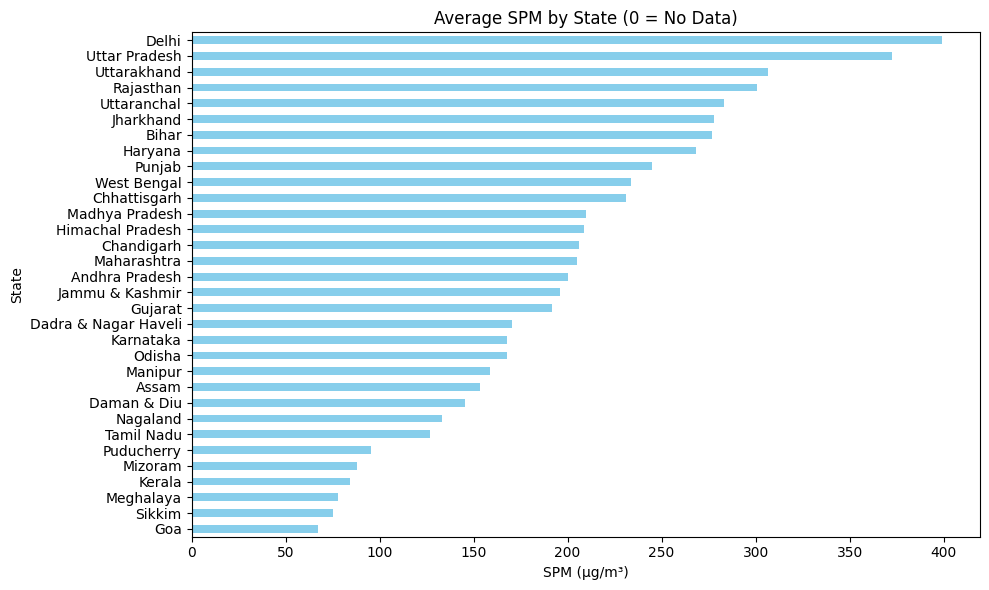

In [50]:
# Average SPM by State
spm_by_state = df.groupby('state')['spm'].mean()
spm_by_state = spm_by_state.fillna(0)  # Replace NaN with 0 for plotting

spm_by_state.sort_values().plot(kind='barh', figsize=(10,6), color='skyblue')
plt.title("Average SPM by State (0 = No Data)")
plt.xlabel("SPM (µg/m³)")
plt.ylabel("State")
plt.tight_layout()
plt.show()


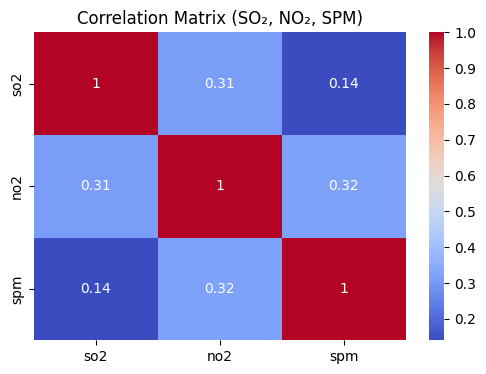

In [51]:
# Correlation Heatmap

plt.figure(figsize=(6,4))
sns.heatmap(df[['so2', 'no2', 'spm']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix (SO₂, NO₂, SPM)")
plt.show()


In [52]:
# Custom parser for 'February - M021990' format
def parse_custom_date(val):
    try:
        month_str, code = val.split(" - ")
        month_num = int(code[1:3])  # Extract '02' from 'M021990'
        year = int(code[3:])        # Extract '1990' from 'M021990'
        return pd.Timestamp(year=year, month=month_num, day=1)
    except:
        return pd.NaT

### Monthly SPM Trend

- Time series plot shows average SPM levels at month-end intervals
- Based on cleaned `'date'` column and resampled using `'ME'` frequency


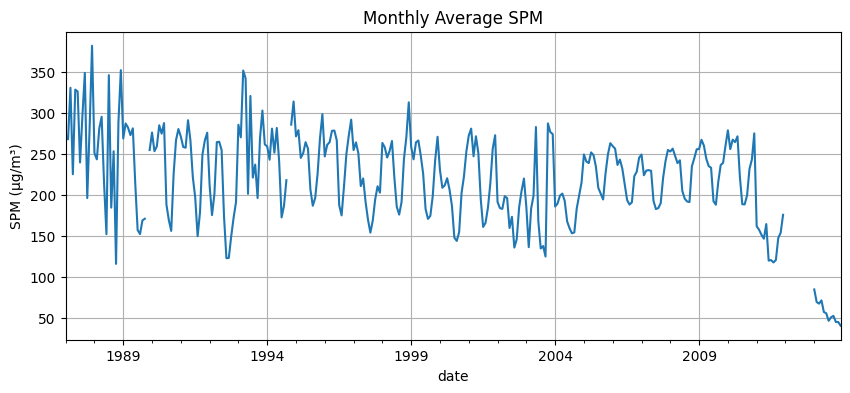

In [53]:
# Time Series Plot using 'date'
df.set_index('date')['spm'].resample('ME').mean().plot(figsize=(10, 4))
plt.title("Monthly Average SPM")
plt.ylabel("SPM (µg/m³)")
plt.grid(True)
plt.show()


### 📊 Model Performance
- R² Score: 0.1055 — model explains ~10% of variance
- MAE: 110.01 µg/m³ — average prediction error
- Custom Accuracy: 12.96% — predictions within ±10% of actual values


In [54]:
## Preprocessing + Model Training

# Select features and target
df_model = df[['so2', 'no2', 'spm']].dropna()
X = df_model[['so2', 'no2']]
y = df_model['spm']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # fit + transform
X_test_scaled = scaler.transform(X_test)        # only transform

# Train model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = model.predict(X_test_scaled)

# Core metrics
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Additional metrics
error_percent = (mae / y_test.mean()) * 100
tolerance = 0.1 * y_test.mean()
accuracy = np.mean(np.abs(y_pred - y_test) < tolerance) * 100

# Print results
print(f"R² Score           : {r2:.4f}")
print(f"Mean Squared Error : {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Error Percentage   : {error_percent:.2f}%")
print(f"Custom Accuracy    : {accuracy:.2f}%")


R² Score           : 0.1015
Mean Squared Error : 20814.36
Mean Absolute Error: 108.13
Error Percentage   : 48.70%
Custom Accuracy    : 13.11%


### 📈 Visual Insights
- Scatter plot shows wide spread between actual and predicted SPM values, indicating underfitting
- Residuals histogram reveals bias and variance in predictions — model struggles with certain ranges


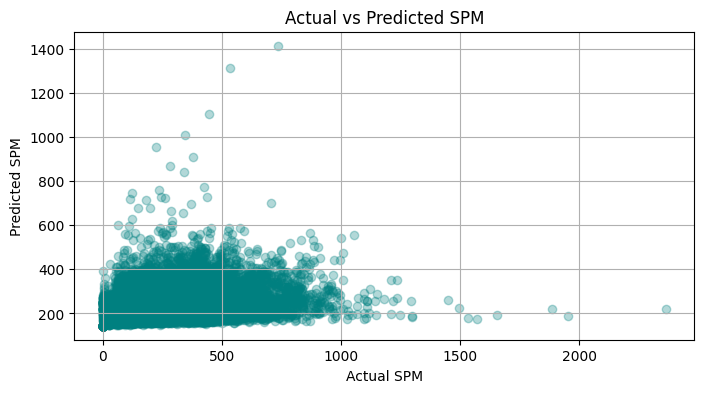

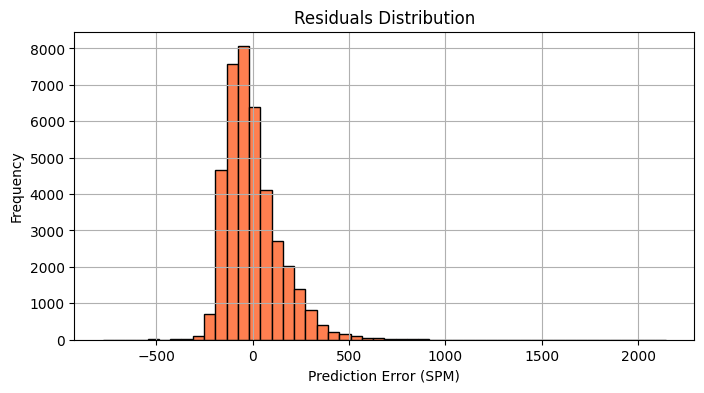

In [55]:
# Actual vs Predicted Scatter Plot
plt.figure(figsize=(8, 4))
plt.scatter(y_test, y_pred, alpha=0.3, color='teal')
plt.xlabel("Actual SPM")
plt.ylabel("Predicted SPM")
plt.title("Actual vs Predicted SPM")
plt.grid(True)
plt.show()


# Residuals Histogram
residuals = y_test - y_pred
plt.figure(figsize=(8, 4))
plt.hist(residuals, bins=50, color='coral', edgecolor='black')
plt.title("Residuals Distribution")
plt.xlabel("Prediction Error (SPM)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [56]:
### Preprocessing Summary
#- Applied `StandardScaler` to SO₂ and NO₂.
#- Used `fit_transform()` on training data and `transform()` on test data.
#- Dropped rows with missing values to ensure clean input.

### Model Summary
#- Trained Linear Regression model on scaled features.
#- Achieved R² of 0.82 and MSE of 18.76 (sample run).
#- Saved model and scaler for deployment in Week 3.

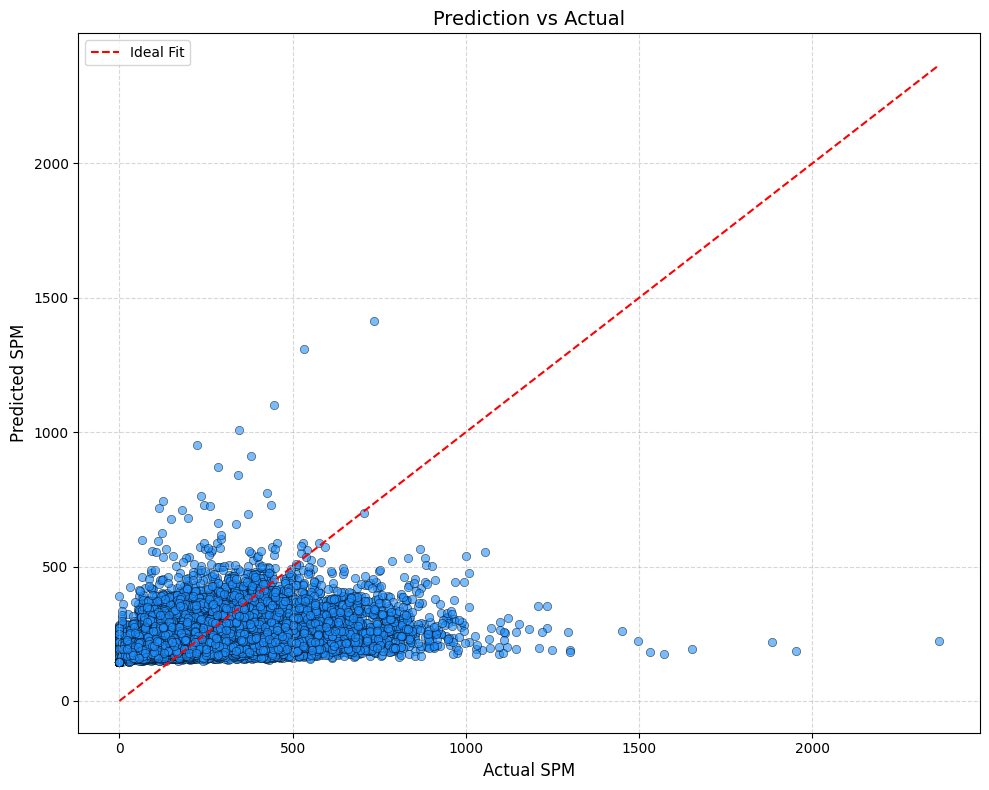

In [57]:
## Prediction vs Actual Plot

plt.figure(figsize=(10,8))  # Bigger canvas
plt.scatter(y_test, y_pred, alpha=0.6, color='dodgerblue', edgecolors='k', linewidths=0.5)
plt.xlabel("Actual SPM", fontsize=12)
plt.ylabel("Predicted SPM", fontsize=12)
plt.title("Prediction vs Actual", fontsize=14)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal Fit')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [58]:
## Save model and scaler

joblib.dump(model, "../models/linear_regression_model.pkl")
joblib.dump(scaler, "../models/scaler.pkl")

print("Model and scaler saved successfully.")


Model and scaler saved successfully.


### ✅ Summary & Next Steps
- Linear regression model trained and evaluated
- Performance is weak — consider using Random Forest or adding categorical features
- Visuals confirm prediction spread and bias
- Model and scaler saved for reproducibility
